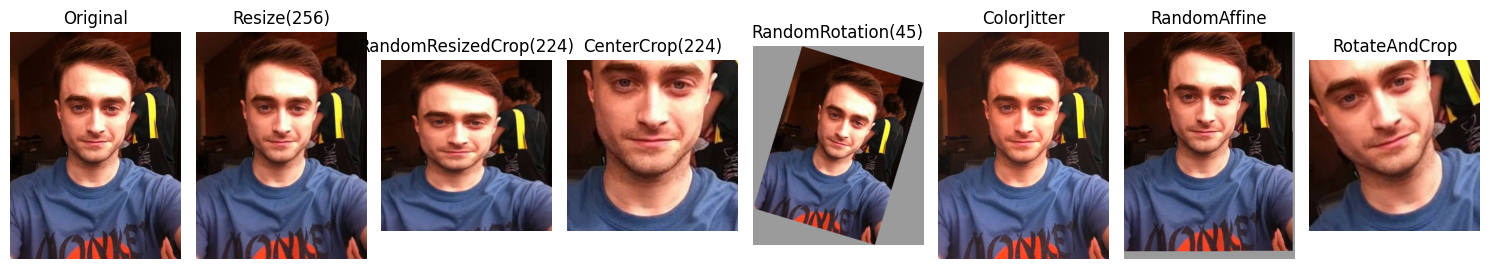

In [35]:
import torch
import torchvision.transforms as T  # type: ignore
from torchvision.io import read_image  # type: ignore
from PIL import Image
import matplotlib.pyplot as plt
import math
import torchvision.transforms.functional as F
from torchvision.transforms import InterpolationMode

def rotatedRectWithMaxArea(w, h, angle):
  """
  Given a rectangle of size wxh that has been rotated by 'angle' (in
  radians), computes the width and height of the largest possible
  axis-aligned rectangle (maximal area) within the rotated rectangle.
  """
  if w <= 0 or h <= 0:
    return 0,0

  width_is_longer = w >= h
  side_long, side_short = (w,h) if width_is_longer else (h,w)

  # since the solutions for angle, -angle and 180-angle are all the same,
  # if suffices to look at the first quadrant and the absolute values of sin,cos:
  sin_a, cos_a = abs(math.sin(angle)), abs(math.cos(angle))
  if side_short <= 2.*sin_a*cos_a*side_long or abs(sin_a-cos_a) < 1e-10:
    # half constrained case: two crop corners touch the longer side,
    #   the other two corners are on the mid-line parallel to the longer line
    x = 0.5*side_short
    wr,hr = (x/sin_a,x/cos_a) if width_is_longer else (x/cos_a,x/sin_a)
  else:
    # fully constrained case: crop touches all 4 sides
    cos_2a = cos_a*cos_a - sin_a*sin_a
    wr,hr = (w*cos_a - h*sin_a)/cos_2a, (h*cos_a - w*sin_a)/cos_2a

  return wr,hr

# Custom transform to Rotate image and zoom to crop out black borders
class RotateCrop(T.RandomRotation):
    def __init__(self, degrees):
        super().__init__(degrees)

    def __call__(self, img):
        # Get original size
        w, h = img.size
        
        # Rotate image
        angle_rad = math.radians(self.get_params(self.degrees))
        img = img.rotate(math.degrees(angle_rad), resample=self.resample, 
                        expand=self.expand, center=self.center, fill=self.fill)
        
        # Calculate maximum rectangle dimensions
        w_rot, h_rot = rotatedRectWithMaxArea(w, h, angle_rad)
        
        # Get center of image
        center_x, center_y = img.size[0] // 2, img.size[1] // 2
        
        # Calculate crop box
        x1 = center_x - w_rot // 2
        y1 = center_y - h_rot // 2
        x2 = center_x + w_rot // 2
        y2 = center_y + h_rot // 2
        
        # Crop to largest inscribed rectangle
        img = img.crop((x1, y1, x2, y2))
        
        # Resize if size is specified
        if self.size:
            img = img.resize(self.size, self.resample)
            
        return img
    
class RotateAndCrop:
    def __init__(self, output_height, output_width, rotation_degree, do_crop=True):
        """
        Args:
            output_height: The height of the image after preprocessing.
            output_width: The width of the image after preprocessing.
            rotation_degree: The degree of rotation on the image.
            do_crop: Perform cropping to remove black edges if True.
        """
        self.output_height = output_height
        self.output_width = output_width
        self.rotation_degree = rotation_degree
        self.do_crop = do_crop

    def _largest_rotated_rect(self, w, h, angle):
        """
        Compute the width and height of the largest axis-aligned rectangle 
        within a rotated rectangle of size w x h.
        """
        quadrant = int(math.floor(angle / (math.pi / 2))) & 3
        sign_alpha = angle if (quadrant & 1) == 0 else math.pi - angle
        alpha = (sign_alpha % math.pi + math.pi) % math.pi

        bb_w = w * math.cos(alpha) + h * math.sin(alpha)
        bb_h = w * math.sin(alpha) + h * math.cos(alpha)

        gamma = math.atan2(bb_w, bb_h) if w < h else math.atan2(bb_h, bb_w)
        delta = math.pi - alpha - gamma

        length = h if w < h else w
        d = length * math.cos(alpha)
        a = d * math.sin(alpha) / math.sin(delta)

        y = a * math.cos(gamma)
        x = y * math.tan(gamma)

        return bb_w - 2 * x, bb_h - 2 * y

    def __call__(self, image):
        """
        Apply the transformation to the input image.
        Args:
            image: A PIL image or tensor.
        Returns:
            A transformed image.
        """
        # Rotate the image
        image = F.rotate(image, angle=self.rotation_degree, interpolation=InterpolationMode.BILINEAR)

        if self.do_crop and self.rotation_degree != 0:
            radians = math.radians(self.rotation_degree)
            lrr_width, lrr_height = self._largest_rotated_rect(self.output_width, self.output_height, radians)

            # Perform center crop
            crop_width = int(lrr_width)
            crop_height = int(lrr_height)
            image = F.center_crop(image, (crop_height, crop_width))

            # Resize to original dimensions
            image = F.resize(image, (self.output_height, self.output_width), interpolation=InterpolationMode.BILINEAR)

        return image

def visualize_transforms(image_path, transforms_list):
    # Load image
    img = Image.open(image_path)

    # Create subplot grid
    n_transforms = len(transforms_list)
    fig = plt.figure(figsize=(15, 5))

    # Plot original
    plt.subplot(1, n_transforms + 1, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    # Apply and plot each transform
    for idx, (name, transform) in enumerate(transforms_list, 1):
        transformed = transform(img)

        # Convert tensor to PIL if needed
        if isinstance(transformed, torch.Tensor):
            transformed = T.ToPILImage()(transformed)

        plt.subplot(1, n_transforms + 1, idx + 1)
        plt.imshow(transformed)
        plt.title(name)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Example transforms to test
transforms_to_test = [
    ("Resize(256)", T.Resize(256)),
    ("RandomResizedCrop(224)", T.RandomResizedCrop(224)),
    ("CenterCrop(224)", T.CenterCrop(224)),
    ("RandomRotation(45)", T.RandomRotation(45, fill=155, expand=True)),
    ("ColorJitter", T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5)),
    ("RandomAffine", T.RandomAffine(degrees=(-10, 10), translate=(0.05, 0.05), scale=(0.95, 1.05), fill=155)),
    # ("RotateCrop", RotateCrop(45)),
    ("RotateAndCrop", RotateAndCrop(300, 300, 20)),
]

# Use the function
image_path = "../temp/unseen/dan2.jpg" 
visualize_transforms(image_path, transforms_to_test)
